## Data processing (function)

In [1]:
import h5py
import hdf5plugin
import numpy as np
import itertools
import torch

# process data in one file
def processData(filename, n_jet = 1000):
    h5 = h5py.File(filename,'r')

    params_3 = ['sv_ptrel',
              'sv_erel',
              'sv_phirel',
              'sv_etarel',
              'sv_deltaR',
              'sv_pt',
              'sv_mass',
              'sv_ntracks',
              'sv_normchi2',
              'sv_dxy',
              'sv_dxysig',
              'sv_d3d',
              'sv_d3dsig',
              'sv_costhetasvpv'
             ]

    params_2 = ['track_ptrel',     
              'track_erel',     
              'track_phirel',     
              'track_etarel',     
              'track_deltaR',
              'track_drminsv',     
              'track_drsubjet1',     
              'track_drsubjet2',
              'track_dz',     
              'track_dzsig',     
              'track_dxy',     
              'track_dxysig',     
              'track_normchi2',     
              'track_quality',     
              'track_dptdpt',     
              'track_detadeta',     
              'track_dphidphi',     
              'track_dxydxy',     
              'track_dzdz',     
              'track_dxydz',     
              'track_dphidxy',     
              'track_dlambdadz',     
              'trackBTag_EtaRel',     
              'trackBTag_PtRatio',     
              'trackBTag_PParRatio',     
              'trackBTag_Sip2dVal',     
              'trackBTag_Sip2dSig',     
              'trackBTag_Sip3dVal',     
              'trackBTag_Sip3dSig',     
              'trackBTag_JetDistVal'
             ]


    labels_qcd = {"label_QCD_b": 53, "label_QCD_bb":51, "label_QCD_c":54,"label_QCD_cc":52,"label_QCD_others": 55}
    label_H_bb = 41
    num_jets = h5["event_no"].shape[0]
    print(num_jets)
    n_particles = h5["track_dxydxy"].shape[-1]

    n_vertices = h5["sv_phirel"].shape[-1]

    # track features
    X = []

    # SV features
    Y = []

    # labels
    y = []
    edge_indices = []
    for jet in range(num_jets):
        if h5["fj_label"][jet] in list(labels_qcd.values()):
            y.append([0,1])
        elif h5["fj_label"][jet] == label_H_bb:
            y.append([1,0])
        else: continue

        x = []
        for feature in params_2:
            x.append(h5[feature][jet])
        X.append(np.array(x).reshape(n_particles,-1))

        y1 = []
        for feature in params_3:
            y1.append(h5[feature][jet])
        Y.append(np.array(y1).reshape(n_vertices,-1))

        # complete graph has n_particles*(n_particles-1)/2 edges, here we double count each edge, so has  n_particles*(n_particles-1) total edges
        pairs = np.stack([[m, n] for (m, n) in itertools.product(range(n_particles), range(n_particles)) if m != n])
        # edge_index = torch.tensor(pairs, dtype=torch.long)
        edge_index = pairs.transpose()
        edge_indices.append(edge_index)

        if jet > n_jet:
            break
    
    return X, Y, y


In [2]:
# # EX
# filename = "/higgs/train/ntuple_merged_10.h5"
# X, Y, y = processData(filename)
# X_train = torch.tensor(X)
# Y_train = torch.tensor(Y)
# print(X_train.shape)

In [3]:
import h5py
import hdf5plugin
import numpy as np
import itertools
import torch
from torch_geometric.data import Data, Dataset
import os

#process data so that number of h_bb=qcd=num_datapoints
files = os.listdir("/higgs/train")
def processData_even(files, num_datapoints = 1000):
#     filename = "/higgs/train/ntuple_merged_44.h5"
#     h5s = []
#     for i in range(10):
#         h5s.append(h5py.File(filename,'r'))
    fs = []
    for f in files:
        if f[-3:] == ".h5": fs.append(f)

    # filename = "/higgs/train/ntuple_merged_44.h5"
    h5s = []
    for i in range(10):
        h5s.append(h5py.File("/higgs/train/"+fs[i],'r'))

    params_3 = ['sv_ptrel',
              'sv_erel',
              'sv_phirel',
              'sv_etarel',
              'sv_deltaR',
              'sv_pt',
              'sv_mass',
              'sv_ntracks',
              'sv_normchi2',
              'sv_dxy',
              'sv_dxysig',
              'sv_d3d',
              'sv_d3dsig',
              'sv_costhetasvpv'
             ]

    params_2 = ['track_ptrel',     
              'track_erel',     
              'track_phirel',     
              'track_etarel',     
              'track_deltaR',
              'track_drminsv',     
              'track_drsubjet1',     
              'track_drsubjet2',
              'track_dz',     
              'track_dzsig',     
              'track_dxy',     
              'track_dxysig',     
              'track_normchi2',     
              'track_quality',     
              'track_dptdpt',     
              'track_detadeta',     
              'track_dphidphi',     
              'track_dxydxy',     
              'track_dzdz',     
              'track_dxydz',     
              'track_dphidxy',     
              'track_dlambdadz',     
              'trackBTag_EtaRel',     
              'trackBTag_PtRatio',     
              'trackBTag_PParRatio',     
              'trackBTag_Sip2dVal',     
              'trackBTag_Sip2dSig',     
              'trackBTag_Sip3dVal',     
              'trackBTag_Sip3dSig',     
              'trackBTag_JetDistVal'
             ]


    labels_qcd = {"label_QCD_b": 53, "label_QCD_bb":51, "label_QCD_c":54,"label_QCD_cc":52,"label_QCD_others": 55}
    label_H_bb = 41
    num_datapoints = num_datapoints
    hbb_count = 0
    qcd_count = 0

    # track features
    X = []

    # SV features
    Y = []

    # labels
    y = []
    edge_indices = []
    for h5 in h5s:
        if qcd_count >= num_datapoints and hbb_count >= num_datapoints:
            break
        num_jets = h5["event_no"].shape[0]
        n_particles = h5["track_dxydxy"].shape[-1]
        n_vertices = h5["sv_phirel"].shape[-1]
        for jet in range(num_jets):

            if h5["fj_label"][jet] in list(labels_qcd.values()) and qcd_count < num_datapoints:
                qcd_count += 1
                y.append([0,1])
            elif h5["fj_label"][jet] == label_H_bb and hbb_count < num_datapoints:
                hbb_count += 1
                y.append([1,0])
            else: continue

            x = []
            for feature in params_2:
                x.append(h5[feature][jet])
            X.append(np.array(x).reshape(n_particles,-1))

            y1 = []
            for feature in params_3:
                y1.append(h5[feature][jet])
            Y.append(np.array(y1).reshape(n_vertices,-1))

            # complete graph has n_particles*(n_particles-1)/2 edges, here we double count each edge, so has  n_particles*(n_particles-1) total edges
            pairs = np.stack([[m, n] for (m, n) in itertools.product(range(n_particles), range(n_particles)) if m != n])
            edge_index = torch.tensor(pairs, dtype=torch.long)
            edge_index = pairs.transpose()
            edge_indices.append(edge_index)

            # if jet > 1000:
                # break
            if qcd_count >= num_datapoints and hbb_count >= num_datapoints:
                break
            print("qcd: ", qcd_count, " hbb: ", hbb_count)
        return X, Y, y

In [4]:
import torch
import itertools

def assign_matrices(N, Nr):
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

    # Create indices for all possible combinations of receivers and senders
    indices = torch.tensor(list(itertools.product(range(N), range(N))), dtype=torch.long, device=device)

    # Remove combinations where receiver and sender are the same
    mask = indices[:, 0] != indices[:, 1]
    indices = indices[mask]

    # Initialize Rr and Rs tensors
    Rr = torch.zeros(N, Nr, device=device)
    Rs = torch.zeros(N, Nr, device=device)

    # Assign 1 to appropriate positions in Rr and Rs
    Rr[indices[:, 0], torch.arange(Nr)] = 1
    Rs[indices[:, 1], torch.arange(Nr)] = 1

#     print("Rr:", Rr)
#     print("Rs:", Rs)
    return Rr, Rs



# Example usage
# Rr, Rs = assign_matrices(5, 20)

In [5]:
def assign_matrices_SV(N, Nt, Nv):
    # Create indices for all possible combinations of keys and values
    indices = torch.tensor(list(itertools.product(range(N), range(Nv))), dtype=torch.long)

    # Initialize Rk and Rv tensors
    Rk = torch.zeros(N, Nt)
    Rv = torch.zeros(Nv, Nt)

    # Assign 1 to appropriate positions in Rk and Rv
    Rk[indices[:, 0], torch.arange(Nt)] = 1
    Rv[indices[:, 1], torch.arange(Nt)] = 1

    # Move tensors to GPU if available
    if torch.cuda.is_available():
        Rk = Rk.cuda()
        Rv = Rv.cuda()

    return Rk,Rv

Rk, Rv = assign_matrices_SV(3, 6, 2)

# print("Rk:", Rk)
# print("Rv:", Rv)



In [6]:
import torch
import itertools
import torch.nn as nn
from torch.nn import Sequential as Seq, Linear as Lin, ReLU, BatchNorm1d
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')


class IN(torch.nn.Module):
    def __init__(self, hidden=60, N_p=30, params=60, N_v=14, params_v=5, De=20, Do=24, softmax=False):
        super(IN, self).__init__()  # Call the superclass's __init__ method
        self.hidden = hidden
        self.Np = N_p  # N
        self.P = params
        self.Npp = self.Np * (self.Np - 1)  # Nr
        self.Nv = N_v
        self.S = params_v
        self.Npv = self.Np * self.Nv  # Nt
        self.De = De
        self.Do = Do
        self.softmax = softmax

        self.fr_pp = Seq(Lin(2 * self.P, self.hidden), ReLU(), Lin(self.hidden, self.De))
        self.fr_pv = Seq(Lin(self.P + self.S, self.hidden), ReLU(), Lin(self.hidden, self.De))
        self.fo = Seq(Lin(self.P + (2 * self.De), self.hidden), ReLU(), Lin(self.hidden, self.Do))
        self.fc = nn.Linear(self.Do, 2)

        self.Rr,self.Rs = assign_matrices(self.Np, self.Npp)
        self.Rk,self.Rv = assign_matrices_SV(self.Np, self.Npv, self.Nv)


    def forward(self, x, y):
        # PF Candidate
        Orr = x @ self.Rr
        Ors = x @ self.Rs
        B = torch.cat([Orr, Ors], 1)

        # First MLP
        B = B.transpose(1, 2).contiguous()
        E = self.fr_pp(B.view(-1, 2 * self.P)).view(-1, self.Npp, self.De)
        del B
        E = torch.transpose(E, 1, 2).contiguous()
        Ebar_pp = (E @ self.Rr.t().contiguous())
        del E

        # Secondary Vertex
        # PF Candidate
        Ork = x @ self.Rk
        Orv = y @ self.Rv
        B = torch.cat([Ork, Orv], 1)

        # First MLP
        B = B.transpose(1, 2).contiguous()
        E = self.fr_pv(B.view(-1, self.S + self.P)).view(-1, self.Npv, self.De)
        del B
        E = E.transpose(1, 2).contiguous()

        #typo in text, see dimention of matrix
        Ebar_vp = (E @ self.Rk.t().contiguous())
        del E


        # Final output maxtrix for particels
        C = torch.cat([x, Ebar_pp, Ebar_vp], 1).transpose(1, 2).contiguous()
        del Ebar_pp
        del Ebar_vp
        # Second MLP
        O = self.fo(C.view(-1, self.P + (2 * self.De))).view(-1,self.Np,self.Do)
        del C


        #Taking the sum of over each particle/vertex
        N = torch.sum(O, dim=1)
        del O


        #Classification MLP
        N = self.fc(N)

        if self.softmax:
            N = nn.Softmax(dim=-1)(N)


        return N









## Data processing

### Training data

In [7]:
X,Y,y = processData_even(files,num_datapoints= 1000)

qcd:  1  hbb:  0
qcd:  2  hbb:  0
qcd:  3  hbb:  0
qcd:  4  hbb:  0
qcd:  5  hbb:  0
qcd:  6  hbb:  0
qcd:  7  hbb:  0
qcd:  8  hbb:  0
qcd:  9  hbb:  0
qcd:  10  hbb:  0
qcd:  11  hbb:  0
qcd:  12  hbb:  0
qcd:  13  hbb:  0
qcd:  14  hbb:  0
qcd:  15  hbb:  0
qcd:  16  hbb:  0
qcd:  17  hbb:  0
qcd:  18  hbb:  0
qcd:  19  hbb:  0
qcd:  20  hbb:  0
qcd:  21  hbb:  0
qcd:  22  hbb:  0
qcd:  23  hbb:  0
qcd:  23  hbb:  1
qcd:  24  hbb:  1
qcd:  25  hbb:  1
qcd:  26  hbb:  1
qcd:  27  hbb:  1
qcd:  28  hbb:  1
qcd:  29  hbb:  1
qcd:  29  hbb:  2
qcd:  30  hbb:  2
qcd:  31  hbb:  2
qcd:  32  hbb:  2
qcd:  33  hbb:  2
qcd:  34  hbb:  2
qcd:  35  hbb:  2
qcd:  36  hbb:  2
qcd:  36  hbb:  3
qcd:  36  hbb:  4
qcd:  37  hbb:  4
qcd:  38  hbb:  4
qcd:  39  hbb:  4
qcd:  40  hbb:  4
qcd:  41  hbb:  4
qcd:  42  hbb:  4
qcd:  43  hbb:  4
qcd:  44  hbb:  4
qcd:  45  hbb:  4
qcd:  46  hbb:  4
qcd:  47  hbb:  4
qcd:  48  hbb:  4
qcd:  49  hbb:  4
qcd:  50  hbb:  4
qcd:  51  hbb:  4
qcd:  51  hbb:  5
q

In [8]:
import os
os.system("nvidia-smi")

Sun Jun  9 17:40:21 2024       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 525.53         CUDA Version: 12.0     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA A100 80GB PCIe          Off |   00000000:88:00.0 Off |                   On |
| N/A   38C    P0             67W /  300W |                  N/A   |     N/A      Default |
|                                         |                        |              Enabled |
+-----------------------------------------+-----

0

In [9]:
X_train = torch.tensor(X)
Y_train = torch.tensor(Y)

/tmp/ipykernel_564/556884966.py:1: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:261.)
  X_train = torch.tensor(X)


In [10]:
# model = IN().to(device)
X_train = X_train.to(device)
Y_train = Y_train.to(device)
label_train = torch.tensor(y).float().to(device)
# result=model(X_train, Y_train)

In [11]:
import os
os.system("nvidia-smi")

Sun Jun  9 17:40:22 2024       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 525.53         CUDA Version: 12.0     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA A100 80GB PCIe          Off |   00000000:88:00.0 Off |                   On |
| N/A   38C    P0             67W /  300W |                  N/A   |     N/A      Default |
|                                         |                        |              Enabled |
+-----------------------------------------+-----

0

### Validation/test data

In [12]:
filename = "/higgs/test/ntuple_merged_0.h5"
X, Y, y = processData(filename, n_jet = 200)
X_test = torch.tensor(X).to(device)
Y_test = torch.tensor(Y).to(device)
label_test= torch.tensor(y).float().to(device)

200000


In [13]:
print(label_test.shape)

torch.Size([202, 2])


In [14]:
model = IN().to(device)

### Trainging loop

In [15]:
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
xentropy = nn.CrossEntropyLoss(reduction="mean")
model.train()
loss_list = []
vali_loss_list = []
for i in range(6000):
    optimizer.zero_grad()
    output = (model(X_train, Y_train)).to(device)
    loss= xentropy(output,label_train)
    loss.backward()
    optimizer.step()


    if(i % 100 == 0):
        loss_list.append(loss)
        with torch.no_grad():
            output_vali = (model(X_test, Y_test)).to(device)
            loss_vali= xentropy(output_vali,label_test)
            vali_loss_list.append(loss_vali)

    if(i % 200 == 0):
        print('loss: ', loss)
#     save loss_list
loss_list_path = os.path.join('loss_list_1.pth')
torch.save(loss_list, loss_list_path)
#     save loss_vali_list
loss_vali_list_path = os.path.join('loss_vali_list_1.pth')
torch.save(vali_loss_list, loss_vali_list_path)
#     save model
IN_path =  os.path.join('model_IN_1.pth')
torch.save(model.state_dict(), IN_path)


loss:  tensor(26.8947, device='cuda:0', grad_fn=<DivBackward1>)
loss:  tensor(0.7837, device='cuda:0', grad_fn=<DivBackward1>)
loss:  tensor(0.4318, device='cuda:0', grad_fn=<DivBackward1>)
loss:  tensor(0.3233, device='cuda:0', grad_fn=<DivBackward1>)
loss:  tensor(0.2406, device='cuda:0', grad_fn=<DivBackward1>)
loss:  tensor(0.2003, device='cuda:0', grad_fn=<DivBackward1>)
loss:  tensor(0.1724, device='cuda:0', grad_fn=<DivBackward1>)
loss:  tensor(0.1506, device='cuda:0', grad_fn=<DivBackward1>)
loss:  tensor(0.1333, device='cuda:0', grad_fn=<DivBackward1>)
loss:  tensor(0.1191, device='cuda:0', grad_fn=<DivBackward1>)
loss:  tensor(0.1067, device='cuda:0', grad_fn=<DivBackward1>)
loss:  tensor(0.0952, device='cuda:0', grad_fn=<DivBackward1>)
loss:  tensor(0.0845, device='cuda:0', grad_fn=<DivBackward1>)
loss:  tensor(0.0774, device='cuda:0', grad_fn=<DivBackward1>)
loss:  tensor(0.0712, device='cuda:0', grad_fn=<DivBackward1>)
loss:  tensor(0.0656, device='cuda:0', grad_fn=<DivBac

## Evaluation

In [16]:
mdl = IN().to(device)
mdl_path = 'model_IN_1.pth'
mdl.load_state_dict(torch.load(mdl_path))

<All keys matched successfully>

In [17]:
def plot_loss(loss_list_path, loss_vali_list_path):
    import torch
    import matplotlib.pyplot as plt

    # Retrieve the lists from the loaded data
    loss_list = torch.load(loss_list_path)
    loss_vali_list = torch.load(loss_vali_list_path)

    
    # Ensure the lists are converted to standard Python lists
    loss_list = [loss.item() if isinstance(loss, torch.Tensor) else loss for loss in loss_list][:20]
    loss_vali_list = [loss.item() if isinstance(loss, torch.Tensor) else loss for loss in loss_vali_list][:20]

    # Plot the lists
    epochs = list(range(0, len(loss_list) * 100, 100))  # X-axis values (every 10th epoch)
    plt.figure(figsize=(10, 5))

    plt.plot(epochs, loss_list, label='training loss')
    plt.plot(epochs, loss_vali_list, label='validation loss')
    

    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Loss over Epochs')
    plt.legend()
    plt.grid(True)
    plt.show()

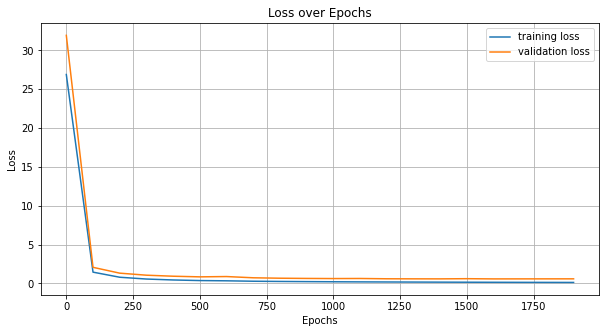

In [18]:
loss_list_path = os.path.join('loss_list_1.pth')
loss_vali_list_path = os.path.join('loss_vali_list_1.pth')
plot_loss(loss_list_path, loss_vali_list_path)

In [19]:
output=mdl(X_train, Y_train)
print(output)

tensor([[  -3.3623,    7.4175],
        [-110.0778, -106.3906],
        [ -10.9532,   -2.3505],
        ...,
        [ -12.0532,  -18.1671],
        [   5.2507,    4.7496],
        [  10.4422,  -18.5203]], device='cuda:0', grad_fn=<AddmmBackward0>)


In [20]:
print(label_train)

tensor([[0., 1.],
        [0., 1.],
        [0., 1.],
        ...,
        [1., 0.],
        [1., 0.],
        [1., 0.]], device='cuda:0')


In [21]:
import torch.nn.functional as F
softmax_output = F.softmax(output, dim=-1)
y_pred = torch.argmax(softmax_output, dim=-1)
y_label = torch.argmax(label_train, dim=-1)
print(torch.sum(y_pred == y_label))

tensor(2000, device='cuda:0')


In [22]:
torch.sum(y_label == 0)

tensor(1000, device='cuda:0')

In [23]:
print(label_test.shape)

torch.Size([202, 2])


In [24]:
import torch.nn.functional as F
output_test = mdl(X_test, Y_test)
softmax_output_t = F.softmax(output_test, dim=-1)
y_pred_test = torch.argmax(softmax_output_t, dim=-1)
y_label_test = torch.argmax(label_test, dim=-1)
print(torch.sum(y_pred_test == y_label_test))

tensor(168, device='cuda:0')


In [38]:
 (y_pred_test == 0).sum()

tensor(50, device='cuda:0')

In [39]:
(y_pred_test[y_label_test==1] == y_label_test[y_label_test==1]).sum()

tensor(151, device='cuda:0')

## Drawing ROC curve and get accuracy

In [40]:
mdl.eval()
with torch.no_grad():
    prediction = mdl(X_test, Y_test)
    out_prediction = F.softmax(prediction, dim=-1)
    out_predictions_numpy = out_prediction.cpu().numpy()

Y_predict = out_predictions_numpy[:, :]
print(Y_predict.shape)

(202, 2)


In [41]:
label_test_numpy = label_test.cpu().numpy()
print(label_test_numpy.shape)

(202, 2)


Accuracy: 83.17%


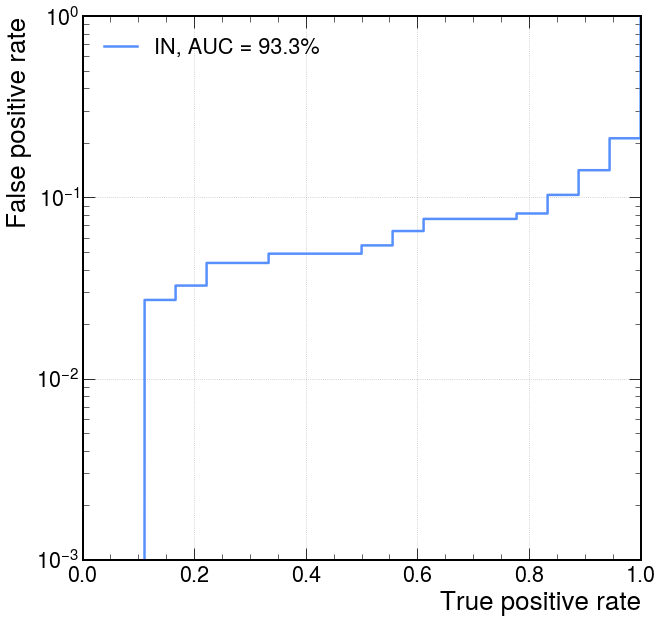

In [42]:
!pip install --upgrade mplhep -q
from sklearn.metrics import roc_curve, auc, accuracy_score
import matplotlib.pyplot as plt
import mplhep as hep

plt.style.use(hep.style.ROOT)
# create ROC curves
fpr_in, tpr_in, threshold_in = roc_curve(label_test_numpy[:, 0], Y_predict[:, 0])

predicted_classes = (Y_predict[:, 1] >= 0.5).astype(int)

# Calculate accuracy
accuracy = accuracy_score(label_test_numpy[:, 1], predicted_classes)

print("Accuracy: {:.2f}%".format(accuracy * 100))
                          
# plot ROC curves
plt.figure()
plt.plot(tpr_in, fpr_in, lw=2.5, label="IN, AUC = {:.1f}%".format(auc(fpr_in, tpr_in) * 100))
plt.xlabel(r"True positive rate")
plt.ylabel(r"False positive rate")
plt.semilogy()
plt.ylim(0.001, 1)
plt.xlim(0, 1)
plt.grid(True)
plt.legend(loc="upper left")
plt.show()